<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/Module10HW_Transformer_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
# Modern Transformer Architecture - Homework
To be submitted as part II of HW4 (last homework)
In this assignment, you'll implement key innovations in modern Transformers:
- **RMSNorm**: Simpler and faster normalization
- **RoPE**: Rotary positional embeddings for better length extrapolation
- **Simplified MHLA**: Efficient attention with reduced KV cache

**What you'll learn:**
- Why modern LLMs use these techniques
- How they improve efficiency and performance
- Trade-offs between different approaches

**Submission:** Submit this completed notebook with all cells executed.

**Grading:**
- Part 1 (RMSNorm): 20 points
- Part 2 (RoPE): 30 points
- Part 3 (MHLA): 35 points
- Part 4 (Integration + Questions): 15 points
Total: 100 points
"""

# ============================================================================
# Setup
# ============================================================================

"""
## Setup and Installation
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import time
import numpy as np
from typing import Optional, Tuple

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Setup complete!")

# ============================================================================
# Part 1: RMSNorm (20 points)
# ============================================================================

"""
## Part 1: RMSNorm - Root Mean Square Normalization

**Background:** LayerNorm centers (zero mean) and scales (unit variance).
RMSNorm only scales, which is simpler and faster while being equally effective in Pre-LN architectures.
**Your task:** Complete the RMSNorm implementation below.
"""

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps

        # TODO: Initialize learnable scale parameter (gamma)
        # Hint: Use nn.Parameter(torch.ones(dim))
        self.gamma = None  # REPLACE THIS LINE

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch, seq_len, dim)
        Returns:
            Normalized tensor of same shape
        """
        # TODO: Implement RMSNorm
        # Step 1: Compute mean of squares along last dimension
        # Hint: mean_sq = (x ** 2).mean(dim=-1, keepdim=True)

        # Step 2: Compute RMS (root mean square)
        # Hint: rms = torch.sqrt(mean_sq + self.eps)

        # Step 3: Normalize by dividing by RMS
        # Hint: x_normalized = x / rms

        # Step 4: Apply learnable scale
        # Hint: return self.gamma * x_normalized

        pass  # REPLACE WITH YOUR IMPLEMENTATION

# Test your implementation
def test_rmsnorm():
    """Test that RMSNorm produces correct scale"""
    print("Testing RMSNorm...")
    norm = RMSNorm(dim=64)
    x = torch.randn(2, 10, 64)
    out = norm(x)

    # Check 1: Output should have RMS ≈ 1
    rms = torch.sqrt((out ** 2).mean(dim=-1))
    assert torch.allclose(rms, torch.ones_like(rms), atol=1e-5), "RMS should be ~1"
    print(f"  ✓ Output RMS: {rms.mean().item():.6f} (should be ~1.0)")

    # Check 2: Compare with LayerNorm - RMSNorm mean is NOT forced to zero
    layer_norm = nn.LayerNorm(64)
    out_ln = layer_norm(x)

    mean_rms = out.mean(dim=-1).abs().mean()
    mean_ln = out_ln.mean(dim=-1).abs().mean()

    print(f"  ✓ RMSNorm output mean: {mean_rms.item():.4f}")
    print(f"  ✓ LayerNorm output mean: {mean_ln.item():.6f} (near zero)")
    print(f"  ✓ RMSNorm does NOT center data (unlike LayerNorm)")

    print("✓ RMSNorm test passed!")
    return out

# Uncomment to test after implementing
# test_rmsnorm()

"""
### Comparison: RMSNorm vs LayerNorm

Let's compare the two normalization methods.
"""

def compare_normalizations():
    """Compare RMSNorm and LayerNorm"""
    dim = 512
    batch, seq_len = 4, 128

    # Create input
    x = torch.randn(batch, seq_len, dim).to(device)

    # Initialize both norms
    rms_norm = RMSNorm(dim).to(device)
    layer_norm = nn.LayerNorm(dim).to(device)

    # Apply both
    out_rms = rms_norm(x)
    out_ln = layer_norm(x)

    # Compare statistics
    print("RMSNorm output - Mean: {:.4f}, Std: {:.4f}".format(
        out_rms.mean().item(), out_rms.std().item()))
    print("LayerNorm output - Mean: {:.4f}, Std: {:.4f}".format(
        out_ln.mean().item(), out_ln.std().item()))

    # Speed comparison
    n_iters = 1000

    # Warmup
    for _ in range(10):
        _ = rms_norm(x)
        _ = layer_norm(x)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    # RMSNorm timing
    start = time.time()
    for _ in range(n_iters):
        _ = rms_norm(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    rms_time = time.time() - start

    # LayerNorm timing
    start = time.time()
    for _ in range(n_iters):
        _ = layer_norm(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    ln_time = time.time() - start

    print(f"\nSpeed comparison ({n_iters} iterations):")
    print(f"RMSNorm: {rms_time:.4f}s")
    print(f"LayerNorm: {ln_time:.4f}s")
    if ln_time > rms_time:
        print(f"Speedup: {ln_time/rms_time:.2f}x")
    else:
        print(f"Note: On CPU, PyTorch's optimized LayerNorm may be faster.")
        print(f"      RMSNorm shows speedups on GPU or with optimized kernels.")

    # Memory comparison
    print(f"\nParameter count:")
    print(f"RMSNorm: {sum(p.numel() for p in rms_norm.parameters())} (only gamma)")
    print(f"LayerNorm: {sum(p.numel() for p in layer_norm.parameters())} (gamma + beta)")

# Uncomment to run comparison after implementing RMSNorm
# compare_normalizations()

"""
**Question 1.1 (5 points - Written):** Why doesn't RMSNorm need to compute the mean?
In what way is "controlling scale" sufficient for gradient stability?

**Your answer here:**


"""

# ============================================================================
# Part 2: Rotary Positional Embeddings (30 points)
# ============================================================================

"""
## Part 2: RoPE - Rotary Positional Embeddings

**Background:** Instead of adding position information to embeddings, RoPE rotates
the query and key vectors based on their position. This encodes *relative* position
in the attention scores.

**Key insight:** After rotation, the dot product between $q_m$ and $k_n$ depends
only on the distance $(m-n)$, not absolute positions.

**Your task:** Implement RoPE following the steps below.
"""

class RotaryEmbedding(nn.Module):
    def __init__(self, dim: int, max_seq_len: int = 2048, base: float = 10000.0):
        """
        Args:
            dim: Embedding dimension (must be even)
            max_seq_len: Maximum sequence length
            base: Base for frequency computation
        """
        super().__init__()
        assert dim % 2 == 0, "Dimension must be even"

        # TODO: Compute frequencies: theta_i = base^(-2i/dim) for i in [0, dim/2)
        # Hint: inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        inv_freq = None  # REPLACE THIS LINE

        # TODO: Precompute position indices [0, 1, 2, ..., max_seq_len-1]
        # Hint: position = torch.arange(max_seq_len).float()
        position = None  # REPLACE THIS LINE

        # TODO: Compute all rotation angles (outer product)
        # Hint: freqs = torch.outer(position, inv_freq)
        # Shape should be (max_seq_len, dim/2)
        freqs = None  # REPLACE THIS LINE

        # Store as buffer (not a parameter, but part of state)
        self.register_buffer('freqs', freqs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply rotary embeddings to input.

        Args:
            x: Input of shape (batch, seq_len, dim)
        Returns:
            Rotated input of same shape
        """
        batch, seq_len, dim = x.shape

        # Get frequencies for this sequence length
        freqs = self.freqs[:seq_len]  # (seq_len, dim/2)

        # TODO: Compute cos and sin of frequencies
        # Hint: cos_freqs = torch.cos(freqs), sin_freqs = torch.sin(freqs)
        cos_freqs = None  # REPLACE THIS LINE
        sin_freqs = None  # REPLACE THIS LINE

        # Reshape x into pairs: (batch, seq_len, dim/2, 2)
        x_reshaped = x.reshape(batch, seq_len, -1, 2)

        # Split into even and odd indices
        x_even = x_reshaped[..., 0]  # (batch, seq_len, dim/2)
        x_odd = x_reshaped[..., 1]   # (batch, seq_len, dim/2)

        # TODO: Apply rotation using rotation matrix:
        # [cos, -sin]
        # [sin,  cos]
        # Hint: x_even_rot = x_even * cos_freqs - x_odd * sin_freqs
        # Hint: x_odd_rot = x_even * sin_freqs + x_odd * cos_freqs
        x_even_rot = None  # REPLACE THIS LINE
        x_odd_rot = None   # REPLACE THIS LINE

        # Stack back together
        x_rotated = torch.stack([x_even_rot, x_odd_rot], dim=-1)

        # Reshape back to original shape
        return x_rotated.reshape(batch, seq_len, dim)

# Test RoPE
def test_rope():
    """Test that RoPE encodes relative positions"""
    print("Testing RoPE...")
    rope = RotaryEmbedding(dim=64)

    # Create separate Q and K vectors (same content, will be rotated differently)
    torch.manual_seed(123)  # For reproducibility
    base_vec = torch.randn(1, 1, 64)  # Single base vector

    # Create Q and K at different positions by repeating the base vector
    q_positions = torch.tensor([0, 10])  # Query at positions 0 and 10
    k_positions = torch.tensor([5, 15])  # Key at positions 5 and 15

    # Create sequences where we place our base vector at specific positions
    seq_len = 20
    Q = torch.zeros(1, seq_len, 64)
    K = torch.zeros(1, seq_len, 64)

    # Place the same base vector at different positions
    Q[0, q_positions[0]] = base_vec[0, 0]
    Q[0, q_positions[1]] = base_vec[0, 0]
    K[0, k_positions[0]] = base_vec[0, 0]
    K[0, k_positions[1]] = base_vec[0, 0]

    # Apply RoPE
    Q_rot = rope(Q)
    K_rot = rope(K)

    # Test relative position property
    # dot(q@pos0, k@pos5) should equal dot(q@pos10, k@pos15) (both have distance 5)
    dot1 = (Q_rot[0, q_positions[0]] * K_rot[0, k_positions[0]]).sum()
    dot2 = (Q_rot[0, q_positions[1]] * K_rot[0, k_positions[1]]).sum()

    print(f"  Dot product at distance 5 (positions 0→5): {dot1:.4f}")
    print(f"  Dot product at distance 5 (positions 10→15): {dot2:.4f}")
    print(f"  Difference: {(dot1 - dot2).abs():.6f}")

    assert torch.allclose(dot1, dot2, atol=1e-3), "Should encode relative position!"
    print("✓ RoPE relative position test passed!")

    # Test length extrapolation
    print("\nTesting length extrapolation...")
    x_long = torch.randn(1, 100, 64)
    x_long_rotated = rope(x_long)
    print(f"  ✓ Can process sequences longer than some typical lengths ({x_long.shape[1]} tokens)")

# Uncomment to test after implementing
# test_rope()

"""
### Visualize RoPE

Let's visualize how RoPE encodes positions.
"""

def visualize_rope():
    """Visualize RoPE attention patterns"""
    rope = RotaryEmbedding(dim=64)

    # Create queries and keys at different positions
    seq_len = 50
    x = torch.randn(1, seq_len, 64)
    x_rotated = rope(x)

    # Compute attention scores (without softmax)
    scores = torch.matmul(x_rotated, x_rotated.transpose(-2, -1))
    scores = scores[0].detach().numpy()  # (seq_len, seq_len)

    # Plot
    plt.figure(figsize=(12, 4))

    # Full attention matrix
    plt.subplot(1, 3, 1)
    plt.imshow(scores, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Score')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title('Attention Scores with RoPE')

    # Attention as function of relative distance
    plt.subplot(1, 3, 2)
    distances = []
    avg_scores = []
    for d in range(25):
        # Get all pairs with distance d
        mask = torch.zeros(seq_len, seq_len)
        for i in range(seq_len - d):
            mask[i, i + d] = 1

        if mask.sum() > 0:
            avg_score = (torch.tensor(scores) * mask).sum() / mask.sum()
            distances.append(d)
            avg_scores.append(avg_score.item())

    plt.plot(distances, avg_scores, marker='o', linewidth=2)
    plt.xlabel('Relative Distance')
    plt.ylabel('Average Attention Score')
    plt.title('Attention vs Relative Position')
    plt.grid(True, alpha=0.3)

    # Show that position 0 has same pattern as position 20
    plt.subplot(1, 3, 3)
    plt.plot(scores[0, :], label='Query at position 0', linewidth=2)
    plt.plot(scores[20, :], label='Query at position 20', linewidth=2, linestyle='--')
    plt.xlabel('Key Position')
    plt.ylabel('Attention Score')
    plt.title('RoPE Relative Position Property')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Notice: The patterns are shifted but have the same shape!")
    print("This shows that RoPE encodes relative position, not absolute position.")

# Uncomment to visualize after implementing
# visualize_rope()

"""
**Question 2.1 (5 points - Written):** Why does RoPE generalize better to longer sequences
than learned absolute positional embeddings?

**Your answer here:**


"""

# ============================================================================
# Part 3: Simplified Multi-Head Latent Attention (35 points)
# ============================================================================

"""
## Part 3: Simplified MHLA

**Background:** Standard attention caches both K and V for all heads, which uses
a lot of memory. MHLA compresses K and V into a lower-dimensional "latent" space.

**Standard attention cache per token:** $2 \times n_{\text{heads}} \times d_{\text{head}}$

**MHLA cache per token:** $d_{\text{latent}}$ (much smaller!)

**Your task:** Implement a simplified single-head version of MHLA.
"""

class SimplifiedLatentAttention(nn.Module):
    def __init__(self, d_model: int = 256, d_latent: int = 64):
        """
        Simplified Multi-Head Latent Attention (single head version)

        Args:
            d_model: Model dimension
            d_latent: Latent dimension (compressed, this is what gets cached)
        """
        super().__init__()
        self.d_model = d_model
        self.d_latent = d_latent
        self.scale = math.sqrt(d_latent)

        # TODO: Initialize projection matrices (all with bias=False)
        # W_DKV: projects input to latent KV space (d_model -> d_latent)
        # W_Q: projects input to query space (d_model -> d_model)
        # W_UK: projects queries to latent space (d_model -> d_latent)
        # W_O: projects latent output back to model space (d_latent -> d_model)
        # Hint: Use nn.Linear(in_features, out_features, bias=False)

        self.W_DKV = None   # REPLACE THIS LINE
        self.W_Q = None     # REPLACE THIS LINE
        self.W_UK = None    # REPLACE THIS LINE
        self.W_O = None     # REPLACE THIS LINE

    def forward(self, x: torch.Tensor, cache: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input of shape (batch, seq_len, d_model)
            cache: Optional cached L_KV from previous steps
        Returns:
            output: (batch, seq_len, d_model)
            L_KV: (batch, total_seq_len, d_latent) for caching
        """
        batch, seq_len, _ = x.shape

        # TODO: Step 1 - Create KV latent (THIS is what gets cached!)
        # Hint: L_KV_new = self.W_DKV(x)
        # Shape: (batch, seq_len, d_latent)
        L_KV_new = None  # REPLACE THIS LINE

        # TODO: Step 2 - Create queries and project to latent space
        # Hint: Q = self.W_Q(x), then QK_T = self.W_UK(Q)
        # QK_T shape: (batch, seq_len, d_latent)
        Q = None       # REPLACE THIS LINE
        QK_T = None    # REPLACE THIS LINE

        # Step 3: Handle cache (for autoregressive generation)
        if cache is not None:
            # Concatenate with previous L_KV
            L_KV = torch.cat([cache, L_KV_new], dim=1)
        else:
            L_KV = L_KV_new

        # TODO: Step 4 - Compute attention scores in latent space
        # Hint: scores = (QK_T @ L_KV.transpose(-2, -1)) / self.scale
        # Shape: (batch, seq_len, total_seq_len)
        scores = None  # REPLACE THIS LINE

        # TODO: Step 5 - Apply softmax
        # Hint: attn_weights = F.softmax(scores, dim=-1)
        attn_weights = None  # REPLACE THIS LINE

        # TODO: Step 6 - Weighted sum of latent values
        # Hint: weighted_latents = attn_weights @ L_KV
        # Shape: (batch, seq_len, d_latent)
        weighted_latents = None  # REPLACE THIS LINE

        # TODO: Step 7 - Project back to model dimension
        # Hint: output = self.W_O(weighted_latents)
        # Shape: (batch, seq_len, d_model)
        output = None  # REPLACE THIS LINE

        return output, L_KV

# Test MHLA
def test_mhla():
    """Test SimplifiedLatentAttention"""
    print("Testing MHLA...")

    d_model, d_latent = 256, 64
    mhla = SimplifiedLatentAttention(d_model, d_latent)

    # Test forward pass
    x = torch.randn(2, 10, d_model)
    output, L_KV = mhla(x)

    # Check shapes
    assert output.shape == x.shape, f"Output shape mismatch: {output.shape} vs {x.shape}"
    assert L_KV.shape == (2, 10, d_latent), f"L_KV shape mismatch: {L_KV.shape}"
    print(f"  ✓ Forward pass: input {x.shape} -> output {output.shape}")
    print(f"  ✓ Cache shape: {L_KV.shape}")

    # Test with cache
    x_next = torch.randn(2, 1, d_model)
    output_next, L_KV_next = mhla(x_next, cache=L_KV)

    assert output_next.shape == (2, 1, d_model), "Cached output shape wrong"
    assert L_KV_next.shape == (2, 11, d_latent), "Cached L_KV shape wrong"
    print(f"  ✓ With cache: new input {x_next.shape} -> cache {L_KV_next.shape}")

    print("✓ MHLA test passed!")

# Uncomment to test after implementing
# test_mhla()

"""
### Standard Attention for Comparison

Here's standard attention implemented for comparison (already complete).
"""

class StandardAttention(nn.Module):
    def __init__(self, d_model: int = 256):
        super().__init__()
        self.d_model = d_model
        self.scale = math.sqrt(d_model)

        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x: torch.Tensor, cache: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        """
        Args:
            x: Input of shape (batch, seq_len, d_model)
            cache: Optional tuple of (cached_K, cached_V)
        Returns:
            output: (batch, seq_len, d_model)
            (K, V): Tuple for caching
        """
        Q = self.W_Q(x)
        K_new = self.W_K(x)
        V_new = self.W_V(x)

        # Handle cache
        if cache is not None:
            K_cache, V_cache = cache
            K = torch.cat([K_cache, K_new], dim=1)
            V = torch.cat([V_cache, V_new], dim=1)
        else:
            K, V = K_new, V_new

        # Attention
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        attn_weights = F.softmax(scores, dim=-1)
        output = attn_weights @ V
        output = self.W_O(output)

        return output, (K, V)

"""
### Compare MHLA vs Standard Attention
"""

def compare_attention_mechanisms():
    """Compare cache sizes and efficiency"""
    d_model = 256
    d_latent = 64
    seq_lengths = [50, 100, 200, 500, 1000, 2000]

    mhla = SimplifiedLatentAttention(d_model, d_latent)
    std_attn = StandardAttention(d_model)

    mhla_cache_sizes = []
    std_cache_sizes = []

    for seq_len in seq_lengths:
        # MHLA cache: only L_KV
        mhla_cache = seq_len * d_latent
        mhla_cache_sizes.append(mhla_cache)

        # Standard attention cache: both K and V
        std_cache = seq_len * d_model * 2
        std_cache_sizes.append(std_cache)

    # Plot
    plt.figure(figsize=(12, 4))

    # Cache size comparison
    plt.subplot(1, 2, 1)
    plt.plot(seq_lengths, np.array(std_cache_sizes)/1000, 'o-', label='Standard Attention', linewidth=2, markersize=8)
    plt.plot(seq_lengths, np.array(mhla_cache_sizes)/1000, 's-', label='MHLA', linewidth=2, markersize=8)
    plt.xlabel('Sequence Length', fontsize=12)
    plt.ylabel('Cache Size (thousands of values)', fontsize=12)
    plt.title('KV Cache Size vs Sequence Length', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Compression ratio
    plt.subplot(1, 2, 2)
    ratios = [std / mhla for std, mhla in zip(std_cache_sizes, mhla_cache_sizes)]
    plt.plot(seq_lengths, ratios, 'o-', linewidth=2, markersize=8, color='green')
    plt.axhline(y=ratios[0], color='gray', linestyle='--', alpha=0.5, label=f'{ratios[0]:.1f}x (constant)')
    plt.xlabel('Sequence Length', fontsize=12)
    plt.ylabel('Compression Ratio', fontsize=12)
    plt.title('Cache Compression: Standard / MHLA', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nFor d_model={d_model}, d_latent={d_latent}:")
    print(f"Compression ratio: {ratios[0]:.1f}x")
    print(f"At seq_len=2000: Standard={std_cache_sizes[-1]:,} vs MHLA={mhla_cache_sizes[-1]:,}")
    print(f"Memory savings: {(1 - mhla_cache_sizes[-1]/std_cache_sizes[-1])*100:.1f}%")

# Uncomment to run comparison after implementing MHLA
# compare_attention_mechanisms()

"""
**Question 3.1 (5 points - Written):** The compression ratio is constant regardless of sequence
length. Why? What does this tell you about where the memory savings come from?

**Your answer here:**


**Question 3.2 (5 points - Written):** MHLA compresses K and V significantly. What information
might be lost? In what scenarios might this hurt model quality?

**Your answer here:**


"""

# ============================================================================
# Part 4: Putting It All Together (15 points)
# ============================================================================

"""
## Part 4: Complete Transformer Block

Now let's combine everything into a modern Transformer block.
"""

class ModernTransformerBlock(nn.Module):
    def __init__(self, d_model: int = 256, d_latent: int = 64, mlp_ratio: int = 4):
        """
        Modern Transformer block with:
        - Pre-LN architecture
        - RMSNorm
        - Simplified MHLA
        - Standard MLP

        Args:
            d_model: Model dimension
            d_latent: Latent dimension for MHLA
            mlp_ratio: MLP expansion ratio
        """
        super().__init__()

        # Normalization (Pre-LN style)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)

        # Attention
        self.attn = SimplifiedLatentAttention(d_model, d_latent)

        # MLP
        d_mlp = d_model * mlp_ratio
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_mlp),
            nn.GELU(),
            nn.Linear(d_mlp, d_model)
        )

    def forward(self, x: torch.Tensor, cache: Optional[torch.Tensor] = None):
        """
        Args:
            x: Input of shape (batch, seq_len, d_model)
            cache: Optional cached L_KV
        Returns:
            output: (batch, seq_len, d_model)
            L_KV: Updated cache
        """
        # TODO: Implement Pre-LN attention block
        # Hint: attn_out, L_KV = self.attn(self.norm1(x), cache)
        # Hint: x = x + attn_out

        # TODO: Implement Pre-LN MLP block
        # Hint: mlp_out = self.mlp(self.norm2(x))
        # Hint: x = x + mlp_out

        pass  # REPLACE WITH YOUR IMPLEMENTATION

# Test the complete block
def test_transformer_block():
    """Test the complete modern transformer block"""
    print("Testing Modern Transformer Block...")

    block = ModernTransformerBlock(d_model=256, d_latent=64)

    # Forward pass
    x = torch.randn(2, 10, 256)
    output, cache = block(x)

    assert output.shape == x.shape, "Output shape mismatch"
    assert cache.shape == (2, 10, 64), "Cache shape mismatch"
    print(f"  ✓ Forward pass: {x.shape} -> {output.shape}")

    # Test with cache (autoregressive)
    x_next = torch.randn(2, 1, 256)
    output_next, cache_next = block(x_next, cache=cache)

    assert output_next.shape == (2, 1, 256), "Cached output shape wrong"
    assert cache_next.shape == (2, 11, 64), "Updated cache shape wrong"
    print(f"  ✓ With cache: {x_next.shape} -> cache {cache_next.shape}")

    print("✓ Transformer block test passed!")
    print(f"\nCache compression: Standard would cache {10 * 256 * 2} values,")
    print(f"MHLA only caches {10 * 64} values = {(10*256*2)/(10*64):.1f}x smaller!")

# Uncomment to test after implementing all components
# test_transformer_block()

"""
### Simple Next-Token Prediction Task

Let's test our modern transformer on a simple task.
"""

def create_toy_dataset(vocab_size: int = 100, seq_len: int = 32, n_samples: int = 1000):
    """Create a simple synthetic dataset for next-token prediction"""
    # Simple pattern: next token = (current token + 1) mod vocab_size
    data = torch.randint(0, vocab_size, (n_samples, seq_len))
    targets = (data + 1) % vocab_size
    return data, targets

def train_model(model, n_epochs: int = 100, vocab_size: int = 100):
    """Simple training loop"""
    d_model = 256

    # Dataset
    train_data, train_targets = create_toy_dataset(vocab_size=vocab_size, n_samples=800, seq_len=32)
    val_data, val_targets = create_toy_dataset(vocab_size=vocab_size, n_samples=200, seq_len=32)

    # Move to device
    train_data = train_data.to(device)
    train_targets = train_targets.to(device)
    val_data = val_data.to(device)
    val_targets = val_targets.to(device)

    # Embedding and output layers
    embedding = nn.Embedding(vocab_size, d_model).to(device)
    output_proj = nn.Linear(d_model, vocab_size).to(device)
    model = model.to(device)

    # Combine into simple model
    params = list(model.parameters()) + list(embedding.parameters()) + list(output_proj.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)

    train_losses = []
    val_losses = []

    print("Training model...")
    for epoch in range(n_epochs):
        # Training
        model.train()
        optimizer.zero_grad()

        # Forward pass
        x_embed = embedding(train_data)  # (batch, seq, d_model)
        output, _ = model(x_embed)
        logits = output_proj(output)  # (batch, seq, vocab)

        # Loss
        loss = F.cross_entropy(
            logits.reshape(-1, vocab_size),
            train_targets.reshape(-1)
        )

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                x_embed_val = embedding(val_data)
                output_val, _ = model(x_embed_val)
                logits_val = output_proj(output_val)
                val_loss = F.cross_entropy(
                    logits_val.reshape(-1, vocab_size),
                    val_targets.reshape(-1)
                )
                val_losses.append(val_loss.item())

                print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return train_losses, val_losses

# Uncomment to train after implementing all components
"""
print("\n" + "="*60)
print("Training modern transformer on toy task...")
print("="*60)
modern_model = ModernTransformerBlock(d_model=256, d_latent=64)
train_losses, val_losses = train_model(modern_model, n_epochs=100)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.7, linewidth=1)
plt.plot([i*10-1 for i in range(1, len(val_losses)+1)], val_losses, 'o-', label='Val Loss', markersize=6, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Progress: Next-Token Prediction', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
"""

# ============================================================================
# Final Questions
# ============================================================================

"""
## Final Questions

**Question 4.1 (3 points - Written):** Imagine you're deploying a chatbot that needs to handle
conversations of 50,000 tokens. Would you use standard attention or MHLA?
Why? What would be the memory savings?

**Your answer here:**


**Question 4.2 (3 points - Written):** What's the main trade-off when using a smaller latent dimension
$d_{\text{latent}}$ in MHLA? How would you choose this hyperparameter?

**Your answer here:**


**Question 4.3 (4 points - Written):** We used Pre-LN (normalize before the block) instead of Post-LN
(normalize after the residual). Why is Pre-LN better for deep networks? Hint:
think about gradient flow.

**Your answer here:**


## Submission Checklist

Before submitting, make sure you have:
- [ ] Implemented RMSNorm correctly (test passes)
- [ ] Implemented RoPE correctly (test passes)
- [ ] Implemented SimplifiedLatentAttention correctly (test passes)
- [ ] Implemented ModernTransformerBlock (test passes)
- [ ] Run all comparison visualizations
- [ ] Answered all written questions

Good luck! 🚀
"""


Using device: cuda
Setup complete!


"\n## Final Questions\n\n**Question 4.1 (3 points - Written):** Imagine you're deploying a chatbot that needs to handle\nconversations of 50,000 tokens. Would you use standard attention or MHLA?\nWhy? What would be the memory savings?\n\n**Your answer here:**\n\n\n**Question 4.2 (3 points - Written):** What's the main trade-off when using a smaller latent dimension\n$d_{\text{latent}}$ in MHLA? How would you choose this hyperparameter?\n\n**Your answer here:**\n\n\n**Question 4.3 (4 points - Written):** We used Pre-LN (normalize before the block) instead of Post-LN\n(normalize after the residual). Why is Pre-LN better for deep networks? Hint:\nthink about gradient flow.\n\n**Your answer here:**\n\n\n## Submission Checklist\n\nBefore submitting, make sure you have:\n- [ ] Implemented RMSNorm correctly (test passes)\n- [ ] Implemented RoPE correctly (test passes)\n- [ ] Implemented SimplifiedLatentAttention correctly (test passes)\n- [ ] Implemented ModernTransformerBlock (test passes)\n

In [2]:
# ============================================================================
# Part 1: RMSNorm (20 points)
# ============================================================================

"""
## Part 1: RMSNorm - Root Mean Square Normalization

**Background:** LayerNorm centers (zero mean) and scales (unit variance).
RMSNorm only scales, which is simpler and faster while being equally effective in Pre-LN architectures.
**Your task:** Complete the RMSNorm implementation below.
"""

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps

        # TODO: Initialize learnable scale parameter (gamma)
        # Hint: Use nn.Parameter(torch.ones(dim))
        self.gamma = nn.Parameter(torch.ones(dim))
        
        #self.gamma = None  # REPLACE THIS LINE

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch, seq_len, dim)
        Returns:
            Normalized tensor of same shape
        """
        # TODO: Implement RMSNorm
        # Step 1: Compute mean of squares along last dimension
        # Hint: mean_sq = (x ** 2).mean(dim=-1, keepdim=True)
        mean_sq = (x ** 2).mean(dim=-1, keepdim=True)

        # Step 2: Compute RMS (root mean square)
        # Hint: rms = torch.sqrt(mean_sq + self.eps)
        rms = torch.sqrt(mean_sq + self.eps)
        
        # Step 3: Normalize by dividing by RMS
        # Hint: x_normalized = x / rms
        x_normalized = x / rms

        # Step 4: Apply learnable scale
        # Hint: return self.gamma * x_normalized
        return self.gamma * x_normalized

        #pass  # REPLACE WITH YOUR IMPLEMENTATION

# Test your implementation
def test_rmsnorm():
    """Test that RMSNorm produces correct scale"""
    print("Testing RMSNorm...")
    norm = RMSNorm(dim=64)
    x = torch.randn(2, 10, 64)
    out = norm(x)

    # Check 1: Output should have RMS ≈ 1
    rms = torch.sqrt((out ** 2).mean(dim=-1))
    assert torch.allclose(rms, torch.ones_like(rms), atol=1e-5), "RMS should be ~1"
    print(f"  ✓ Output RMS: {rms.mean().item():.6f} (should be ~1.0)")

    # Check 2: Compare with LayerNorm - RMSNorm mean is NOT forced to zero
    layer_norm = nn.LayerNorm(64)
    out_ln = layer_norm(x)

    mean_rms = out.mean(dim=-1).abs().mean()
    mean_ln = out_ln.mean(dim=-1).abs().mean()

    print(f"  ✓ RMSNorm output mean: {mean_rms.item():.4f}")
    print(f"  ✓ LayerNorm output mean: {mean_ln.item():.6f} (near zero)")
    print(f"  ✓ RMSNorm does NOT center data (unlike LayerNorm)")

    print("✓ RMSNorm test passed!")
    return out

# Uncomment to test after implementing
# test_rmsnorm()

"""
### Comparison: RMSNorm vs LayerNorm

Let's compare the two normalization methods.
"""

def compare_normalizations():
    """Compare RMSNorm and LayerNorm"""
    dim = 512
    batch, seq_len = 4, 128

    # Create input
    x = torch.randn(batch, seq_len, dim).to(device)

    # Initialize both norms
    rms_norm = RMSNorm(dim).to(device)
    layer_norm = nn.LayerNorm(dim).to(device)

    # Apply both
    out_rms = rms_norm(x)
    out_ln = layer_norm(x)

    # Compare statistics
    print("RMSNorm output - Mean: {:.4f}, Std: {:.4f}".format(
        out_rms.mean().item(), out_rms.std().item()))
    print("LayerNorm output - Mean: {:.4f}, Std: {:.4f}".format(
        out_ln.mean().item(), out_ln.std().item()))

    # Speed comparison
    n_iters = 1000

    # Warmup
    for _ in range(10):
        _ = rms_norm(x)
        _ = layer_norm(x)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    # RMSNorm timing
    start = time.time()
    for _ in range(n_iters):
        _ = rms_norm(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    rms_time = time.time() - start

    # LayerNorm timing
    start = time.time()
    for _ in range(n_iters):
        _ = layer_norm(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    ln_time = time.time() - start

    print(f"\nSpeed comparison ({n_iters} iterations):")
    print(f"RMSNorm: {rms_time:.4f}s")
    print(f"LayerNorm: {ln_time:.4f}s")
    if ln_time > rms_time:
        print(f"Speedup: {ln_time/rms_time:.2f}x")
    else:
        print(f"Note: On CPU, PyTorch's optimized LayerNorm may be faster.")
        print(f"      RMSNorm shows speedups on GPU or with optimized kernels.")

    # Memory comparison
    print(f"\nParameter count:")
    print(f"RMSNorm: {sum(p.numel() for p in rms_norm.parameters())} (only gamma)")
    print(f"LayerNorm: {sum(p.numel() for p in layer_norm.parameters())} (gamma + beta)")

# Uncomment to run comparison after implementing RMSNorm
compare_normalizations()

"""
**Question 1.1 (5 points - Written):** Why doesn't RMSNorm need to compute the mean?
In what way is "controlling scale" sufficient for gradient stability?

**Your answer here:**

RMSNorm is only scaling, it is not centering the mean around zero so there is no need to compute the mean. We are providing a consistent scale across batches and sequences with RMSNorm rather than LayerNorm which does this but while also centering the mean around zero.
Controlling scale supports gradient stability as the variance is normalized via root-mean-square for activations, this ensures some stability during backpropagation without needing to center the mean around zero since we are pre-layer-normalization.


"""


RMSNorm output - Mean: -0.0002, Std: 1.0000
LayerNorm output - Mean: -0.0000, Std: 1.0000

Speed comparison (1000 iterations):
RMSNorm: 0.0741s
LayerNorm: 0.0203s
Note: On CPU, PyTorch's optimized LayerNorm may be faster.
      RMSNorm shows speedups on GPU or with optimized kernels.

Parameter count:
RMSNorm: 512 (only gamma)
LayerNorm: 1024 (gamma + beta)


'\n**Question 1.1 (5 points - Written):** Why doesn\'t RMSNorm need to compute the mean?\nIn what way is "controlling scale" sufficient for gradient stability?\n\n**Your answer here:**\n\nRMSNorm is only scaling, it is not centering the mean around zero so there is no need to compute the mean. We are providing a consistent scale across batches and sequences with RMSNorm rather than LayerNorm which does this but while also centering the mean around zero.\nControlling scale supports gradient stability as the variance is normalized via root-mean-square for activations, this ensures some stability during backpropagation without needing to center the mean around zero since we are pre-layer-normalization.\n\n\n'

In [3]:
# ============================================================================
# Part 2: Rotary Positional Embeddings (30 points)
# ============================================================================

"""
## Part 2: RoPE - Rotary Positional Embeddings

**Background:** Instead of adding position information to embeddings, RoPE rotates
the query and key vectors based on their position. This encodes *relative* position
in the attention scores.

**Key insight:** After rotation, the dot product between $q_m$ and $k_n$ depends
only on the distance $(m-n)$, not absolute positions.

**Your task:** Implement RoPE following the steps below.
"""

class RotaryEmbedding(nn.Module):
    def __init__(self, dim: int, max_seq_len: int = 2048, base: float = 10000.0):
        """
        Args:
            dim: Embedding dimension (must be even)
            max_seq_len: Maximum sequence length
            base: Base for frequency computation
        """
        super().__init__()
        assert dim % 2 == 0, "Dimension must be even"

        # TODO: Compute frequencies: theta_i = base^(-2i/dim) for i in [0, dim/2)
        # Hint: inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        #inv_freq = None  # REPLACE THIS LINE

        # TODO: Precompute position indices [0, 1, 2, ..., max_seq_len-1]
        # Hint: position = torch.arange(max_seq_len).float()
        position = torch.arange(max_seq_len).float()
        #position = None  # REPLACE THIS LINE

        # TODO: Compute all rotation angles (outer product)
        # Hint: freqs = torch.outer(position, inv_freq)
        # Shape should be (max_seq_len, dim/2)
        freqs = torch.outer(position, inv_freq)
        assert freqs.shape == (max_seq_len, dim // 2), f"Expected shape (max_seq_len, {dim // 2}), but got {freqs.shape}"
        #freqs = None  # REPLACE THIS LINE

        # Store as buffer (not a parameter, but part of state)
        self.register_buffer('freqs', freqs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply rotary embeddings to input.

        Args:
            x: Input of shape (batch, seq_len, dim)
        Returns:
            Rotated input of same shape
        """
        batch, seq_len, dim = x.shape

        # Get frequencies for this sequence length
        freqs = self.freqs[:seq_len]  # (seq_len, dim/2)

        # TODO: Compute cos and sin of frequencies
        # Hint: cos_freqs = torch.cos(freqs), sin_freqs = torch.sin(freqs)
        cos_freqs = torch.cos(freqs)
        sin_freqs = torch.sin(freqs)
        #cos_freqs = None  # REPLACE THIS LINE
        #sin_freqs = None  # REPLACE THIS LINE

        # Reshape x into pairs: (batch, seq_len, dim/2, 2)
        x_reshaped = x.reshape(batch, seq_len, -1, 2)

        # Split into even and odd indices
        x_even = x_reshaped[..., 0]  # (batch, seq_len, dim/2)
        x_odd = x_reshaped[..., 1]   # (batch, seq_len, dim/2)

        # TODO: Apply rotation using rotation matrix:
        # [cos, -sin]
        # [sin,  cos]
        # Hint: x_even_rot = x_even * cos_freqs - x_odd * sin_freqs
        # Hint: x_odd_rot = x_even * sin_freqs + x_odd * cos_freqs
        x_even_rot = x_even * cos_freqs - x_odd * sin_freqs
        x_odd_rot = x_even * sin_freqs + x_odd * cos_freqs
        #x_even_rot = None  # REPLACE THIS LINE
        #x_odd_rot = None   # REPLACE THIS LINE

        # Stack back together
        x_rotated = torch.stack([x_even_rot, x_odd_rot], dim=-1)

        # Reshape back to original shape
        return x_rotated.reshape(batch, seq_len, dim)

# Test RoPE
def test_rope():
    """Test that RoPE encodes relative positions"""
    print("Testing RoPE...")
    rope = RotaryEmbedding(dim=64)

    # Create separate Q and K vectors (same content, will be rotated differently)
    torch.manual_seed(123)  # For reproducibility
    base_vec = torch.randn(1, 1, 64)  # Single base vector

    # Create Q and K at different positions by repeating the base vector
    q_positions = torch.tensor([0, 10])  # Query at positions 0 and 10
    k_positions = torch.tensor([5, 15])  # Key at positions 5 and 15

    # Create sequences where we place our base vector at specific positions
    seq_len = 20
    Q = torch.zeros(1, seq_len, 64)
    K = torch.zeros(1, seq_len, 64)

    # Place the same base vector at different positions
    Q[0, q_positions[0]] = base_vec[0, 0]
    Q[0, q_positions[1]] = base_vec[0, 0]
    K[0, k_positions[0]] = base_vec[0, 0]
    K[0, k_positions[1]] = base_vec[0, 0]

    # Apply RoPE
    Q_rot = rope(Q)
    K_rot = rope(K)

    # Test relative position property
    # dot(q@pos0, k@pos5) should equal dot(q@pos10, k@pos15) (both have distance 5)
    dot1 = (Q_rot[0, q_positions[0]] * K_rot[0, k_positions[0]]).sum()
    dot2 = (Q_rot[0, q_positions[1]] * K_rot[0, k_positions[1]]).sum()

    print(f"  Dot product at distance 5 (positions 0→5): {dot1:.4f}")
    print(f"  Dot product at distance 5 (positions 10→15): {dot2:.4f}")
    print(f"  Difference: {(dot1 - dot2).abs():.6f}")

    assert torch.allclose(dot1, dot2, atol=1e-3), "Should encode relative position!"
    print("✓ RoPE relative position test passed!")

    # Test length extrapolation
    print("\nTesting length extrapolation...")
    x_long = torch.randn(1, 100, 64)
    x_long_rotated = rope(x_long)
    print(f"  ✓ Can process sequences longer than some typical lengths ({x_long.shape[1]} tokens)")

# Uncomment to test after implementing
test_rope()

"""
### Visualize RoPE

Let's visualize how RoPE encodes positions.
"""

def visualize_rope():
    """Visualize RoPE attention patterns"""
    rope = RotaryEmbedding(dim=64)

    # Create queries and keys at different positions
    seq_len = 50
    x = torch.randn(1, seq_len, 64)
    x_rotated = rope(x)

    # Compute attention scores (without softmax)
    scores = torch.matmul(x_rotated, x_rotated.transpose(-2, -1))
    scores = scores[0].detach().numpy()  # (seq_len, seq_len)

    # Plot
    plt.figure(figsize=(12, 4))

    # Full attention matrix
    plt.subplot(1, 3, 1)
    plt.imshow(scores, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Score')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title('Attention Scores with RoPE')

    # Attention as function of relative distance
    plt.subplot(1, 3, 2)
    distances = []
    avg_scores = []
    for d in range(25):
        # Get all pairs with distance d
        mask = torch.zeros(seq_len, seq_len)
        for i in range(seq_len - d):
            mask[i, i + d] = 1

        if mask.sum() > 0:
            avg_score = (torch.tensor(scores) * mask).sum() / mask.sum()
            distances.append(d)
            avg_scores.append(avg_score.item())

    plt.plot(distances, avg_scores, marker='o', linewidth=2)
    plt.xlabel('Relative Distance')
    plt.ylabel('Average Attention Score')
    plt.title('Attention vs Relative Position')
    plt.grid(True, alpha=0.3)

    # Show that position 0 has same pattern as position 20
    plt.subplot(1, 3, 3)
    plt.plot(scores[0, :], label='Query at position 0', linewidth=2)
    plt.plot(scores[20, :], label='Query at position 20', linewidth=2, linestyle='--')
    plt.xlabel('Key Position')
    plt.ylabel('Attention Score')
    plt.title('RoPE Relative Position Property')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Notice: The patterns are shifted but have the same shape!")
    print("This shows that RoPE encodes relative position, not absolute position.")

# Uncomment to visualize after implementing
# visualize_rope()

"""
**Question 2.1 (5 points - Written):** Why does RoPE generalize better to longer sequences
than learned absolute positional embeddings?

**Your answer here:**

Learned absolute positional embeddings set a fixed positional embeddings globally, so a position specific vector is added to each tokens embedding. This limits the dimensionality to be the same as the tokens embeddings. Relative position embeddings like RoPE
handle longer sequences better as each tokens embedding has a relative direction to the other embeddings of different tokens, such that each word is looking at other words and how far apart they are. Longer sequences require changing positional encodings as each 
new token is searched you need that token positional information but also its relative distance to the other tokens.

"""

Testing RoPE...
  Dot product at distance 5 (positions 0→5): 57.3730
  Dot product at distance 5 (positions 10→15): 57.3731
  Difference: 0.000008
✓ RoPE relative position test passed!

Testing length extrapolation...
  ✓ Can process sequences longer than some typical lengths (100 tokens)


'\n**Question 2.1 (5 points - Written):** Why does RoPE generalize better to longer sequences\nthan learned absolute positional embeddings?\n\n**Your answer here:**\n\nLearned absolute positional embeddings set a fixed positional embeddings globally, so a position specific vector is added to each tokens embedding. This limits the dimensionality to be the same as the tokens embeddings. Relative position embeddings like RoPE\nhandle longer sequences better as each tokens embedding has a relative direction to the other embeddings of different tokens, such that each word is looking at other words and how far apart they are. Longer sequences require changing positional encodings as each \nnew token is searched you need that token positional information but also its relative distance to the other tokens.\n\n'

Testing MHLA...
  ✓ Forward pass: input torch.Size([2, 10, 256]) -> output torch.Size([2, 10, 256])
  ✓ Cache shape: torch.Size([2, 10, 64])
  ✓ With cache: new input torch.Size([2, 1, 256]) -> cache torch.Size([2, 11, 64])
✓ MHLA test passed!


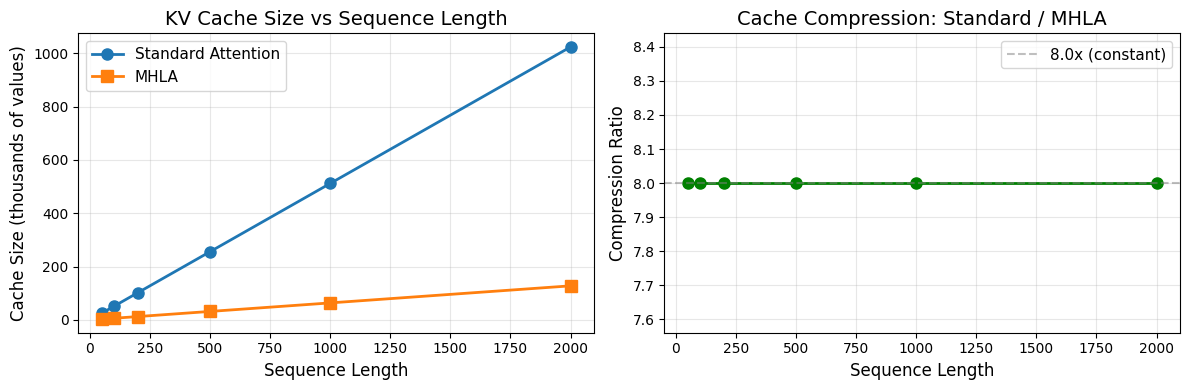


For d_model=256, d_latent=64:
Compression ratio: 8.0x
At seq_len=2000: Standard=1,024,000 vs MHLA=128,000
Memory savings: 87.5%


'\n**Question 3.1 (5 points - Written):** The compression ratio is constant regardless of sequence\nlength. Why? What does this tell you about where the memory savings come from?\n\n**Your answer here:**\n\nThe compression ratio is constant because it only depends on the dimension space not the sequence length. Our standard attention is caching K and V matrixes but MHLA is compressing these into a single latent vector. For our memroy savings this means it \ncomes from the latent spaces (of lower dimension).\n\n\n**Question 3.2 (5 points - Written):** MHLA compresses K and V significantly. What information\nmight be lost? In what scenarios might this hurt model quality?\n\n**Your answer here:**\n\nInformation about minute detail say token level would be lost and information about patterns across heads which would lead to less complex findings but a quicker more general learning by the model. This would hurt if you are looking for specific outcomes for \nthe model to focus on like minute

In [4]:
# ============================================================================
# Part 3: Simplified Multi-Head Latent Attention (35 points)
# ============================================================================

"""
## Part 3: Simplified MHLA

**Background:** Standard attention caches both K and V for all heads, which uses
a lot of memory. MHLA compresses K and V into a lower-dimensional "latent" space.

**Standard attention cache per token:** $2 \times n_{\text{heads}} \times d_{\text{head}}$

**MHLA cache per token:** $d_{\text{latent}}$ (much smaller!)

**Your task:** Implement a simplified single-head version of MHLA.
"""

class SimplifiedLatentAttention(nn.Module):
    def __init__(self, d_model: int = 256, d_latent: int = 64):
        """
        Simplified Multi-Head Latent Attention (single head version)

        Args:
            d_model: Model dimension
            d_latent: Latent dimension (compressed, this is what gets cached)
        """
        super().__init__()
        self.d_model = d_model
        self.d_latent = d_latent
        self.scale = math.sqrt(d_latent)

        # TODO: Initialize projection matrices (all with bias=False)
        # W_DKV: projects input to latent KV space (d_model -> d_latent)
        # W_Q: projects input to query space (d_model -> d_model)
        # W_UK: projects queries to latent space (d_model -> d_latent)
        # W_O: projects latent output back to model space (d_latent -> d_model)
        # Hint: Use nn.Linear(in_features, out_features, bias=False)
        self.W_DKV = nn.Linear(d_model, d_latent, bias=False)
        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_UK = nn.Linear(d_model, d_latent, bias=False)
        self.W_O = nn.Linear(d_latent, d_model, bias=False)
        
        #self.W_DKV = None   # REPLACE THIS LINE
        #self.W_Q = None     # REPLACE THIS LINE
        #self.W_UK = None    # REPLACE THIS LINE
        #self.W_O = None     # REPLACE THIS LINE

    def forward(self, x: torch.Tensor, cache: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input of shape (batch, seq_len, d_model)
            cache: Optional cached L_KV from previous steps
        Returns:
            output: (batch, seq_len, d_model)
            L_KV: (batch, total_seq_len, d_latent) for caching
        """
        batch, seq_len, _ = x.shape

        # TODO: Step 1 - Create KV latent (THIS is what gets cached!)
        # Hint: L_KV_new = self.W_DKV(x)
        # Shape: (batch, seq_len, d_latent)
        L_KV_new = self.W_DKV(x)

        #L_KV_new = None  # REPLACE THIS LINE

        # TODO: Step 2 - Create queries and project to latent space
        # Hint: Q = self.W_Q(x), then QK_T = self.W_UK(Q)
        # QK_T shape: (batch, seq_len, d_latent)
        Q = self.W_Q(x)
        QK_T = self.W_UK(Q)
        #Q = None       # REPLACE THIS LINE
        #QK_T = None    # REPLACE THIS LINE

        # Step 3: Handle cache (for autoregressive generation)
        if cache is not None:
            # Concatenate with previous L_KV
            L_KV = torch.cat([cache, L_KV_new], dim=1)
        else:
            L_KV = L_KV_new

        # TODO: Step 4 - Compute attention scores in latent space
        # Hint: scores = (QK_T @ L_KV.transpose(-2, -1)) / self.scale
        # Shape: (batch, seq_len, total_seq_len)
        scores = (QK_T @ L_KV.transpose(-2, -1)) / self.scale
        #scores = None  # REPLACE THIS LINE

        # TODO: Step 5 - Apply softmax
        # Hint: attn_weights = F.softmax(scores, dim=-1)
        attn_weights = F.softmax(scores, dim=-1)
        #attn_weights = None  # REPLACE THIS LINE

        # TODO: Step 6 - Weighted sum of latent values
        # Hint: weighted_latents = attn_weights @ L_KV
        # Shape: (batch, seq_len, d_latent)
        weighted_latents = attn_weights @ L_KV
        #weighted_latents = None  # REPLACE THIS LINE\
        
        # TODO: Step 7 - Project back to model dimension
        # Hint: output = self.W_O(weighted_latents)
        # Shape: (batch, seq_len, d_model)
        output = self.W_O(weighted_latents)
        #output = None  # REPLACE THIS LINE

        return output, L_KV

# Test MHLA
def test_mhla():
    """Test SimplifiedLatentAttention"""
    print("Testing MHLA...")

    d_model, d_latent = 256, 64
    mhla = SimplifiedLatentAttention(d_model, d_latent)

    # Test forward pass
    x = torch.randn(2, 10, d_model)
    output, L_KV = mhla(x)

    # Check shapes
    assert output.shape == x.shape, f"Output shape mismatch: {output.shape} vs {x.shape}"
    assert L_KV.shape == (2, 10, d_latent), f"L_KV shape mismatch: {L_KV.shape}"
    print(f"  ✓ Forward pass: input {x.shape} -> output {output.shape}")
    print(f"  ✓ Cache shape: {L_KV.shape}")

    # Test with cache
    x_next = torch.randn(2, 1, d_model)
    output_next, L_KV_next = mhla(x_next, cache=L_KV)

    assert output_next.shape == (2, 1, d_model), "Cached output shape wrong"
    assert L_KV_next.shape == (2, 11, d_latent), "Cached L_KV shape wrong"
    print(f"  ✓ With cache: new input {x_next.shape} -> cache {L_KV_next.shape}")

    print("✓ MHLA test passed!")

# Uncomment to test after implementing
test_mhla()

"""
### Standard Attention for Comparison

Here's standard attention implemented for comparison (already complete).
"""

class StandardAttention(nn.Module):
    def __init__(self, d_model: int = 256):
        super().__init__()
        self.d_model = d_model
        self.scale = math.sqrt(d_model)

        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x: torch.Tensor, cache: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        """
        Args:
            x: Input of shape (batch, seq_len, d_model)
            cache: Optional tuple of (cached_K, cached_V)
        Returns:
            output: (batch, seq_len, d_model)
            (K, V): Tuple for caching
        """
        Q = self.W_Q(x)
        K_new = self.W_K(x)
        V_new = self.W_V(x)

        # Handle cache
        if cache is not None:
            K_cache, V_cache = cache
            K = torch.cat([K_cache, K_new], dim=1)
            V = torch.cat([V_cache, V_new], dim=1)
        else:
            K, V = K_new, V_new

        # Attention
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        attn_weights = F.softmax(scores, dim=-1)
        output = attn_weights @ V
        output = self.W_O(output)

        return output, (K, V)

"""
### Compare MHLA vs Standard Attention
"""

def compare_attention_mechanisms():
    """Compare cache sizes and efficiency"""
    d_model = 256
    d_latent = 64
    seq_lengths = [50, 100, 200, 500, 1000, 2000]

    mhla = SimplifiedLatentAttention(d_model, d_latent)
    std_attn = StandardAttention(d_model)

    mhla_cache_sizes = []
    std_cache_sizes = []

    for seq_len in seq_lengths:
        # MHLA cache: only L_KV
        mhla_cache = seq_len * d_latent
        mhla_cache_sizes.append(mhla_cache)

        # Standard attention cache: both K and V
        std_cache = seq_len * d_model * 2
        std_cache_sizes.append(std_cache)

    # Plot
    plt.figure(figsize=(12, 4))

    # Cache size comparison
    plt.subplot(1, 2, 1)
    plt.plot(seq_lengths, np.array(std_cache_sizes)/1000, 'o-', label='Standard Attention', linewidth=2, markersize=8)
    plt.plot(seq_lengths, np.array(mhla_cache_sizes)/1000, 's-', label='MHLA', linewidth=2, markersize=8)
    plt.xlabel('Sequence Length', fontsize=12)
    plt.ylabel('Cache Size (thousands of values)', fontsize=12)
    plt.title('KV Cache Size vs Sequence Length', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Compression ratio
    plt.subplot(1, 2, 2)
    ratios = [std / mhla for std, mhla in zip(std_cache_sizes, mhla_cache_sizes)]
    plt.plot(seq_lengths, ratios, 'o-', linewidth=2, markersize=8, color='green')
    plt.axhline(y=ratios[0], color='gray', linestyle='--', alpha=0.5, label=f'{ratios[0]:.1f}x (constant)')
    plt.xlabel('Sequence Length', fontsize=12)
    plt.ylabel('Compression Ratio', fontsize=12)
    plt.title('Cache Compression: Standard / MHLA', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nFor d_model={d_model}, d_latent={d_latent}:")
    print(f"Compression ratio: {ratios[0]:.1f}x")
    print(f"At seq_len=2000: Standard={std_cache_sizes[-1]:,} vs MHLA={mhla_cache_sizes[-1]:,}")
    print(f"Memory savings: {(1 - mhla_cache_sizes[-1]/std_cache_sizes[-1])*100:.1f}%")

# Uncomment to run comparison after implementing MHLA
compare_attention_mechanisms()

"""
**Question 3.1 (5 points - Written):** The compression ratio is constant regardless of sequence
length. Why? What does this tell you about where the memory savings come from?

**Your answer here:**

The compression ratio is constant because it only depends on the dimension space not the sequence length. Our standard attention is caching K and V matrixes but MHLA is compressing these into a single latent vector. For our memroy savings this means it 
comes from the latent spaces (of lower dimension).


**Question 3.2 (5 points - Written):** MHLA compresses K and V significantly. What information
might be lost? In what scenarios might this hurt model quality?

**Your answer here:**

Information about minute detail say token level would be lost and information about patterns across heads which would lead to less complex findings but a quicker more general learning by the model. This would hurt if you are looking for specific outcomes for 
the model to focus on like minute details about specific token, embeddings, or positions and if you want a deep learning of complex features (that say individual features span a wide number of tokens but show only minimally in total) then the model would like 
perform poorly.

"""

Testing Modern Transformer Block...
  ✓ Forward pass: torch.Size([2, 10, 256]) -> torch.Size([2, 10, 256])
  ✓ With cache: torch.Size([2, 1, 256]) -> cache torch.Size([2, 11, 64])
✓ Transformer block test passed!

Cache compression: Standard would cache 5120 values,
MHLA only caches 640 values = 8.0x smaller!

Training modern transformer on toy task...
Training model...
Epoch 10/100 - Train Loss: 0.2848, Val Loss: 0.1502
Epoch 20/100 - Train Loss: 0.0011, Val Loss: 0.0008
Epoch 30/100 - Train Loss: 0.0001, Val Loss: 0.0001
Epoch 40/100 - Train Loss: 0.0001, Val Loss: 0.0000
Epoch 50/100 - Train Loss: 0.0000, Val Loss: 0.0000
Epoch 60/100 - Train Loss: 0.0000, Val Loss: 0.0000
Epoch 70/100 - Train Loss: 0.0000, Val Loss: 0.0000
Epoch 80/100 - Train Loss: 0.0000, Val Loss: 0.0000
Epoch 90/100 - Train Loss: 0.0000, Val Loss: 0.0000
Epoch 100/100 - Train Loss: 0.0000, Val Loss: 0.0000


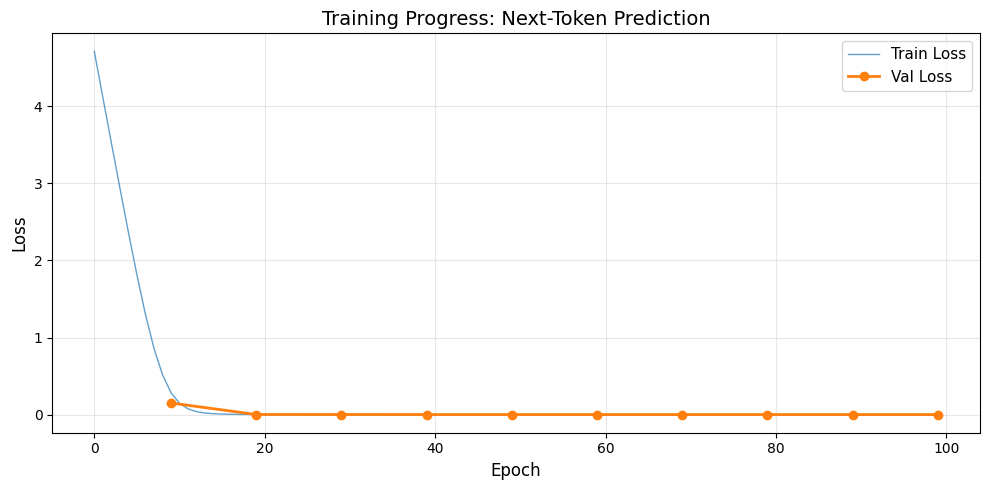


Final training loss: 0.0000
Final validation loss: 0.0000


"\n## Final Questions\n\n**Question 4.1 (3 points - Written):** Imagine you're deploying a chatbot that needs to handle\nconversations of 50,000 tokens. Would you use standard attention or MHLA?\nWhy? What would be the memory savings?\n\n**Your answer here:**\n\nI would use MHLA to greatly reduce the number of parameters and therefore cache per token. For 50k tokens, the memory savings would be say model dimensions = 256 and latent dimension = 64. The MHLA cache per token would be 64 just like above at a 8x rate so \nthe memory savings would be 50k x 512 = 25.6M and 50k x 64 = 3.2M so you are left with about 12.5% of memory used from the standard attentino of 25.6M (87.5% reduction).\n\n\n**Question 4.2 (3 points - Written):** What's the main trade-off when using a smaller latent dimension\n$d_{\text{latent}}$ in MHLA? How would you choose this hyperparameter?\n\n**Your answer here:**\n\nYou lose a good deal of information in the compression amd matrix manipulation. You would look at t

In [9]:
# ============================================================================
# Part 4: Putting It All Together (15 points)
# ============================================================================

"""
## Part 4: Complete Transformer Block

Now let's combine everything into a modern Transformer block.
"""

class ModernTransformerBlock(nn.Module):
    def __init__(self, d_model: int = 256, d_latent: int = 64, mlp_ratio: int = 4):
        """
        Modern Transformer block with:
        - Pre-LN architecture
        - RMSNorm
        - Simplified MHLA
        - Standard MLP

        Args:
            d_model: Model dimension
            d_latent: Latent dimension for MHLA
            mlp_ratio: MLP expansion ratio
        """
        super().__init__()

        # Normalization (Pre-LN style)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)

        # Attention
        self.attn = SimplifiedLatentAttention(d_model, d_latent)

        # MLP
        d_mlp = d_model * mlp_ratio
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_mlp),
            nn.GELU(),
            nn.Linear(d_mlp, d_model)
        )

    def forward(self, x: torch.Tensor, cache: Optional[torch.Tensor] = None):
        """
        Args:
            x: Input of shape (batch, seq_len, d_model)
            cache: Optional cached L_KV
        Returns:
            output: (batch, seq_len, d_model)
            L_KV: Updated cache
        """
        # TODO: Implement Pre-LN attention block
        # Hint: attn_out, L_KV = self.attn(self.norm1(x), cache)
        # Hint: x = x + attn_out
        attn_out, L_KV = self.attn(self.norm1(x), cache)
        x = x + attn_out
        
        # TODO: Implement Pre-LN MLP block
        # Hint: mlp_out = self.mlp(self.norm2(x))
        # Hint: x = x + mlp_out
        mlp_out = self.mlp(self.norm2(x))
        x = x + mlp_out
        
        return x, L_KV
        #pass  # REPLACE WITH YOUR IMPLEMENTATION
        

# Test the complete block
def test_transformer_block():
    """Test the complete modern transformer block"""
    print("Testing Modern Transformer Block...")

    block = ModernTransformerBlock(d_model=256, d_latent=64)

    # Forward pass
    x = torch.randn(2, 10, 256)
    output, cache = block(x)

    assert output.shape == x.shape, "Output shape mismatch"
    assert cache.shape == (2, 10, 64), "Cache shape mismatch"
    print(f"  ✓ Forward pass: {x.shape} -> {output.shape}")

    # Test with cache (autoregressive)
    x_next = torch.randn(2, 1, 256)
    output_next, cache_next = block(x_next, cache=cache)

    assert output_next.shape == (2, 1, 256), "Cached output shape wrong"
    assert cache_next.shape == (2, 11, 64), "Updated cache shape wrong"
    print(f"  ✓ With cache: {x_next.shape} -> cache {cache_next.shape}")

    print("✓ Transformer block test passed!")
    print(f"\nCache compression: Standard would cache {10 * 256 * 2} values,")
    print(f"MHLA only caches {10 * 64} values = {(10*256*2)/(10*64):.1f}x smaller!")

# Uncomment to test after implementing all components
test_transformer_block()

"""
### Simple Next-Token Prediction Task

Let's test our modern transformer on a simple task.
"""

def create_toy_dataset(vocab_size: int = 100, seq_len: int = 32, n_samples: int = 1000):
    """Create a simple synthetic dataset for next-token prediction"""
    # Simple pattern: next token = (current token + 1) mod vocab_size
    data = torch.randint(0, vocab_size, (n_samples, seq_len))
    targets = (data + 1) % vocab_size
    return data, targets

def train_model(model, n_epochs: int = 100, vocab_size: int = 100):
    """Simple training loop"""
    d_model = 256

    # Dataset
    train_data, train_targets = create_toy_dataset(vocab_size=vocab_size, n_samples=800, seq_len=32)
    val_data, val_targets = create_toy_dataset(vocab_size=vocab_size, n_samples=200, seq_len=32)

    # Move to device
    train_data = train_data.to(device)
    train_targets = train_targets.to(device)
    val_data = val_data.to(device)
    val_targets = val_targets.to(device)

    # Embedding and output layers
    embedding = nn.Embedding(vocab_size, d_model).to(device)
    output_proj = nn.Linear(d_model, vocab_size).to(device)
    model = model.to(device)

    # Combine into simple model
    params = list(model.parameters()) + list(embedding.parameters()) + list(output_proj.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)

    train_losses = []
    val_losses = []

    print("Training model...")
    for epoch in range(n_epochs):
        # Training
        model.train()
        optimizer.zero_grad()

        # Forward pass
        x_embed = embedding(train_data)  # (batch, seq, d_model)
        output, _ = model(x_embed)
        logits = output_proj(output)  # (batch, seq, vocab)

        # Loss
        loss = F.cross_entropy(
            logits.reshape(-1, vocab_size),
            train_targets.reshape(-1)
        )

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                x_embed_val = embedding(val_data)
                output_val, _ = model(x_embed_val)
                logits_val = output_proj(output_val)
                val_loss = F.cross_entropy(
                    logits_val.reshape(-1, vocab_size),
                    val_targets.reshape(-1)
                )
                val_losses.append(val_loss.item())

                print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return train_losses, val_losses

# Uncomment to train after implementing all components

print("\n" + "="*60)
print("Training modern transformer on toy task...")
print("="*60)
modern_model = ModernTransformerBlock(d_model=256, d_latent=64)
train_losses, val_losses = train_model(modern_model, n_epochs=100)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.7, linewidth=1)
plt.plot([i*10-1 for i in range(1, len(val_losses)+1)], val_losses, 'o-', label='Val Loss', markersize=6, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Progress: Next-Token Prediction', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")


# ============================================================================
# Final Questions
# ============================================================================

"""
## Final Questions

**Question 4.1 (3 points - Written):** Imagine you're deploying a chatbot that needs to handle
conversations of 50,000 tokens. Would you use standard attention or MHLA?
Why? What would be the memory savings?

**Your answer here:**

I would use MHLA to greatly reduce the number of parameters and therefore cache per token. For 50k tokens, the memory savings would be say model dimensions = 256 and latent dimension = 64. The MHLA cache per token would be 64 just like above at a 8x rate so 
the memory savings would be 50k x 512 = 25.6M and 50k x 64 = 3.2M so you are left with about 12.5% of memory used from the standard attentino of 25.6M (87.5% reduction).


**Question 4.2 (3 points - Written):** What's the main trade-off when using a smaller latent dimension
$d_{\text{latent}}$ in MHLA? How would you choose this hyperparameter?

**Your answer here:**

You lose a good deal of information in the compression amd matrix manipulation. You would look at the problem being solved and consider whether you want less compression for greater information retention, more compression so greater memory savings and speed 
but losing a greater deal of information or somewhere inbetween. Usually though in our examples and papers online there is some standardization like 64 latents, 128, 256 etc. leaving d_model / 4 = d_latent as a good starting point.


**Question 4.3 (4 points - Written):** We used Pre-LN (normalize before the block) instead of Post-LN
(normalize after the residual). Why is Pre-LN better for deep networks? Hint:
think about gradient flow.

**Your answer here:**

Pre-LayerNormalization is better for deep network as the backpropagation does not need to span every layer fixing on stabilizing variance and mean but rather just variance. In a deep network each forward could have a very long backpropagation and we reduce 
this complexity by foregoing the need to center the mean. The exploding gradient and vanishing gradient problems exist for both Post-LN and Pre-LN however by normalizing the sub-layer inputs in Pre-LNwe get better convergence and greatly reduce the vanishing 
gradient problem.


## Submission Checklist

Before submitting, make sure you have:
- [ ] Implemented RMSNorm correctly (test passes)
- [ ] Implemented RoPE correctly (test passes)
- [ ] Implemented SimplifiedLatentAttention correctly (test passes)
- [ ] Implemented ModernTransformerBlock (test passes)
- [ ] Run all comparison visualizations
- [ ] Answered all written questions

Good luck! 🚀
"""